✅ Directories created: Training/{stock_data, models, charts}

🚀 ADVANCED STOCK PRICE PREDICTION SYSTEM

============================================================

📊 AVAILABLE STOCKS:

AAPL     - Apple Inc.

TSLA     - Tesla Inc.

GOOGL    - Alphabet Inc. (Google)

MSFT     - Microsoft Corporation

AMZN     - Amazon.com Inc.

META     - Meta Platforms Inc.

NVDA     - NVIDIA Corporation

NFLX     - Netflix Inc.

BTC-USD  - Bitcoin USD

ETH-USD  - Ethereum USD

SPY      - SPDR S&P 500 ETF

QQQ      - Invesco QQQ Trust

JPM      - JPMorgan Chase & Co.

JNJ      - Johnson & Johnson

V        - Visa Inc.

PG       - Procter & Gamble Co.

DIS      - Walt Disney Co.

NKE      - Nike Inc.

BA       - Boeing Co.

XOM      - Exxon Mobil Corp.

KO       - Coca-Cola Co.

✅ Selected: AAPL - Apple Inc.

📥 Downloading data...

✅ Downloaded 1255 days (2020-10-21 to 2025-10-20)

============================================================

🤖 TRAINING PREDICTION MODELS

============================================================

🔄 Training model for 1 Day prediction...

📈 Performance (1 Day): MAE=$7.66 | RMSE=$9.74 | R²=0.7035

🔄 Training model for 5 Days prediction...

📈 Performance (5 Days): MAE=$12.98 | RMSE=$16.05 | R²=0.2417

🔄 Training model for 21 Days prediction...

📈 Performance (21 Days): MAE=$21.85 | RMSE=$26.89 | R²=-0.9179

============================================================

📈 PREDICTION RESULTS

============================================================

💰 Current Price: $262.24

🎯 1 DAY: $229.45 (-32.79 | -12.50%) → 🔻 STRONG SELL

🎯 1 WEEK: $226.29 (-35.95 | -13.71%) → 🔻 STRONG SELL

🎯 1 MONTH: $240.94 (-21.30 | -8.12%) → 🔻 STRONG SELL

📊 Generating advanced visualizations...

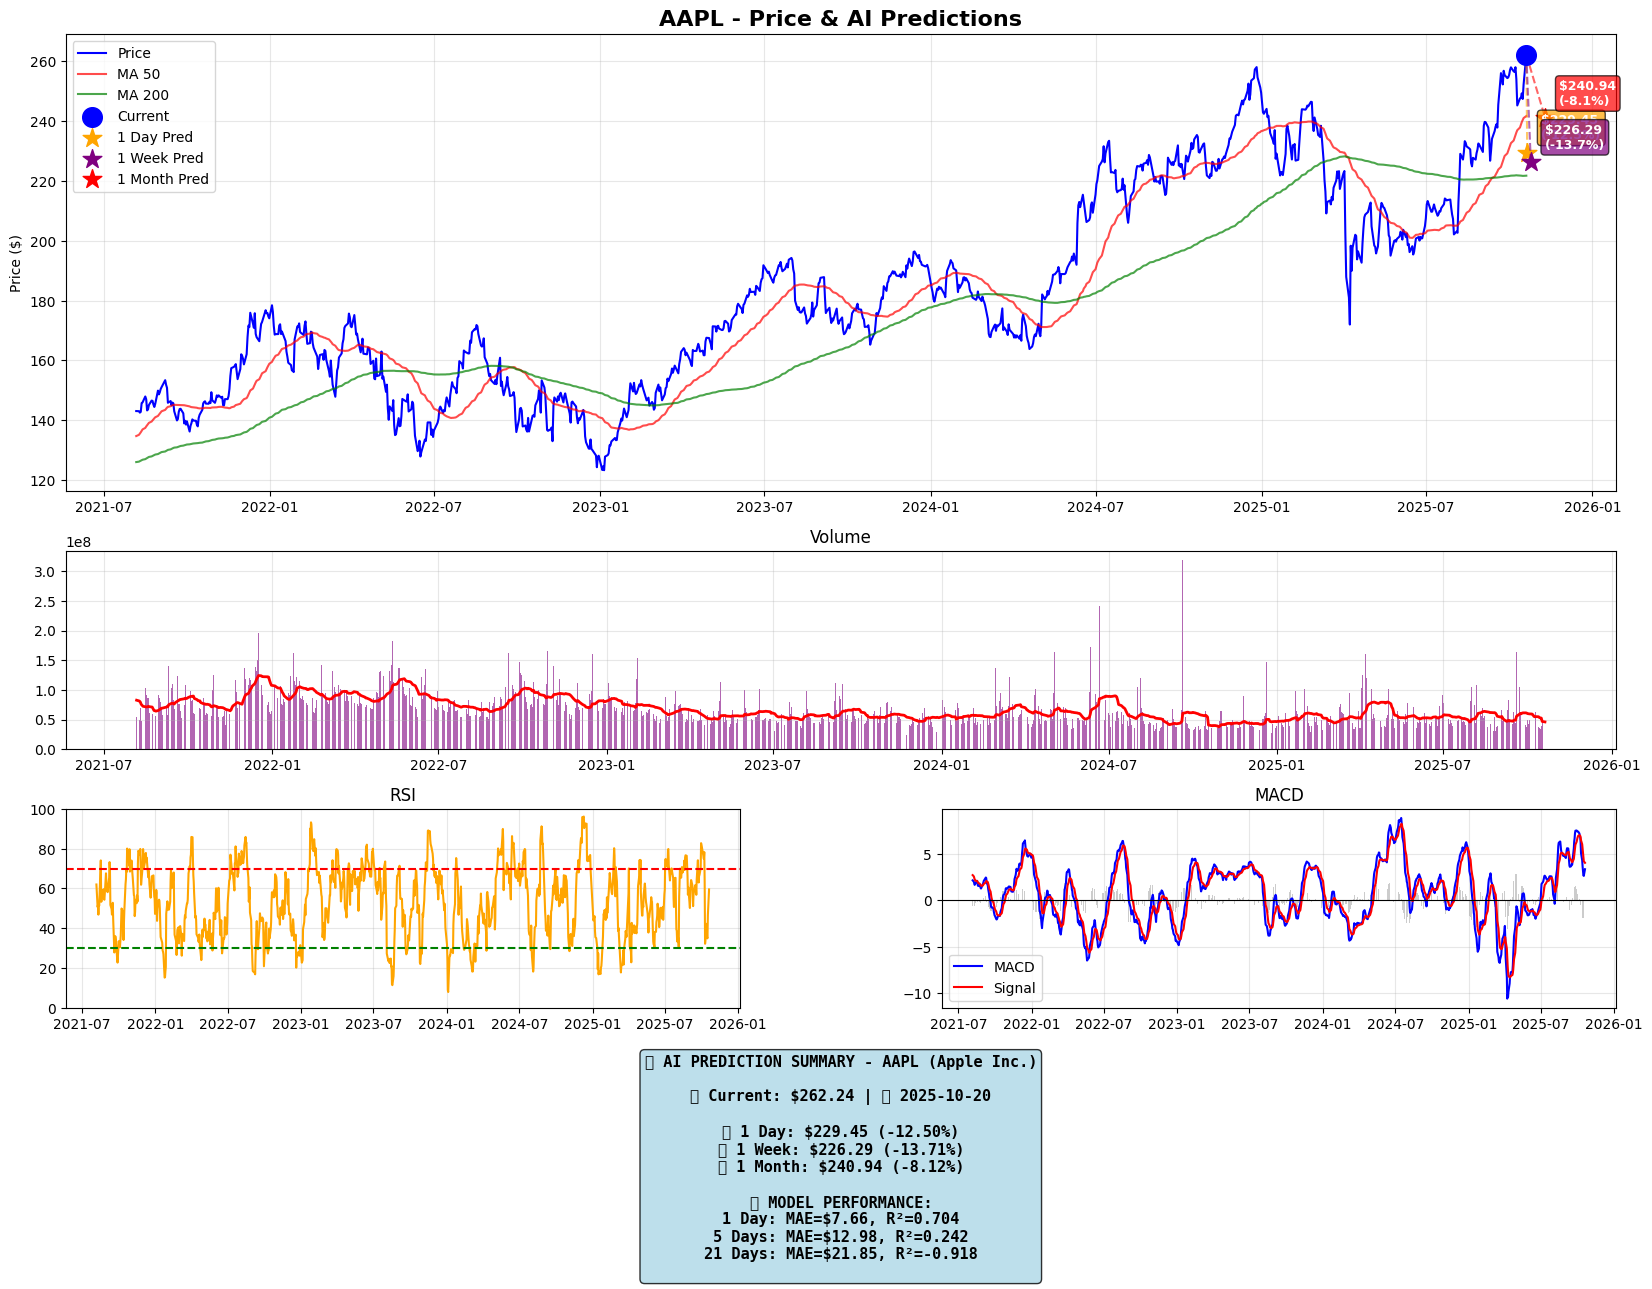

✅ Visualizations saved!

💾 Saving models...

✅ Models and metadata saved.

============================================================

✅ ANALYSIS COMPLETE

============================================================

📁 Outputs saved in Training/ directory.

💡 To reload: joblib.load('Training/models/AAPL_predictor.pkl')

In [7]:
# -------------------[IMPORT MODULES]----------------------- #
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import warnings
from datetime import datetime, timedelta
from typing import Dict, Optional, Tuple, Any

warnings.filterwarnings('ignore')

# -------------------[STOCK DATABASE]----------------------- #
STOCK_DATABASE = {
    'AAPL': 'Apple Inc.',
    'TSLA': 'Tesla Inc.',
    'GOOGL': 'Alphabet Inc. (Google)',
    'MSFT': 'Microsoft Corporation',
    'AMZN': 'Amazon.com Inc.',
    'META': 'Meta Platforms Inc.',
    'NVDA': 'NVIDIA Corporation',
    'NFLX': 'Netflix Inc.',
    'BTC-USD': 'Bitcoin USD',
    'ETH-USD': 'Ethereum USD',
    'SPY': 'SPDR S&P 500 ETF',
    'QQQ': 'Invesco QQQ Trust',
    'JPM': 'JPMorgan Chase & Co.',
    'JNJ': 'Johnson & Johnson',
    'V': 'Visa Inc.',
    'PG': 'Procter & Gamble Co.',
    'DIS': 'Walt Disney Co.',
    'NKE': 'Nike Inc.',
    'BA': 'Boeing Co.',
    'XOM': 'Exxon Mobil Corp.',
    'KO': 'Coca-Cola Co.'
}

# -------------------[UTILITY FUNCTIONS]----------------------- #
def create_directories() -> None:
    """Create required directories if they don't exist."""
    paths = ['Training/stock_data', 'Training/models', 'Training/charts']
    for path in paths:
        os.makedirs(path, exist_ok=True)
    print("✅ Directories created: Training/{stock_data, models, charts}")

def find_stock(search_term: str) -> Dict[str, str]:
    """Search for stock by symbol or name (case-insensitive)."""
    matches = {}
    term = search_term.strip()
    if not term:
        return {}
    for symbol, name in STOCK_DATABASE.items():
        if term.upper() in symbol or term.lower() in name.lower():
            matches[symbol] = name
    return matches

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Flatten MultiIndex columns if present."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# -------------------[TECHNICAL INDICATORS]----------------------- #
def calculate_technical_indicators(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate technical indicators for visualization."""
    df = data.copy()
    df = flatten_columns(df)

    close = df['Close']
    volume = df['Volume']

    # Moving Averages
    for window in [7, 20, 50, 200]:
        df[f'MA_{window}'] = close.rolling(window).mean()

    # EMA & MACD
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # RSI
    delta = close.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta).clip(lower=0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    bb_mid = close.rolling(20).mean()
    bb_std = close.rolling(20).std()
    df['BB_Upper'] = bb_mid + (bb_std * 2)
    df['BB_Lower'] = bb_mid - (bb_std * 2)
    df['BB_Middle'] = bb_mid

    # Volume MA
    df['Volume_MA'] = volume.rolling(20).mean()

    return df

# -------------------[PREDICTION ENGINE]----------------------- #
class StockPricePredictor:
    def __init__(self):
        self.model: Optional[RandomForestRegressor] = None
        self.scaler: StandardScaler = StandardScaler()
        self.feature_columns: Optional[list] = None
        self.is_trained: bool = False
        self.ticker: Optional[str] = None
        self.company_name: Optional[str] = None
        self.training_metrics: Dict[str, Dict[str, Any]] = {}

    def prepare_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Engineer features for model training."""
        df = data.copy()
        df = flatten_columns(df)

        close = df['Close']
        open_price = df['Open']
        high = df['High']
        low = df['Low']
        volume = df['Volume']

        # Price features
        df['Price_Range'] = high - low
        df['Price_Change'] = close - open_price
        df['Close_Open_Ratio'] = close / open_price
        df['High_Low_Ratio'] = high / low

        # Moving averages & ratios
        for w in [5, 7, 10, 20, 50, 200]:
            ma = close.rolling(w).mean()
            df[f'MA_{w}'] = ma
            df[f'Price_vs_MA_{w}'] = close / ma

        # EMA & MACD
        ema_12 = close.ewm(span=12, adjust=False).mean()
        ema_26 = close.ewm(span=26, adjust=False).mean()
        df['EMA_12'] = ema_12
        df['EMA_26'] = ema_26
        macd = ema_12 - ema_26
        df['MACD'] = macd
        df['MACD_Signal'] = macd.ewm(span=9, adjust=False).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # RSI
        delta = close.diff()
        gain = delta.clip(lower=0).rolling(14).mean()
        loss = (-delta).clip(lower=0).rolling(14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        bb_mid = close.rolling(20).mean()
        bb_std = close.rolling(20).std()
        df['BB_Upper'] = bb_mid + (bb_std * 2)
        df['BB_Lower'] = bb_mid - (bb_std * 2)
        df['BB_Position'] = (close - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

        # Volume
        vol_ma = volume.rolling(20).mean()
        df['Volume_MA'] = vol_ma
        df['Volume_Ratio'] = volume / vol_ma

        # Momentum & Volatility
        for p in [5, 10, 20]:
            df[f'Momentum_{p}'] = close - close.shift(p)
            df[f'ROC_{p}'] = (df[f'Momentum_{p}'] / close.shift(p)) * 100
        df['Volatility_20'] = close.rolling(20).std()
        df['Daily_Return'] = close.pct_change()

        # Lags
        for lag in [1, 2, 3]:
            df[f'Close_Lag_{lag}'] = close.shift(lag)
            df[f'Volume_Lag_{lag}'] = volume.shift(lag)

        # Targets
        df['Target_1_Day'] = close.shift(-1)
        df['Target_5_Days'] = close.shift(-5)
        df['Target_21_Days'] = close.shift(-21)

        return df

    def train_model(self, data: pd.DataFrame, target_horizon: str = '1_Day') -> bool:
        """Train model for a given prediction horizon."""
        print(f"🔄 Training model for {target_horizon.replace('_', ' ')} prediction...")

        df = self.prepare_features(data)
        df_clean = df.dropna()

        target_col = f'Target_{target_horizon}'
        if target_col not in df_clean.columns:
            print(f"❌ Target column '{target_col}' not found.")
            return False

        feature_candidates = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'Price_Range', 'Price_Change', 'Close_Open_Ratio', 'High_Low_Ratio',
            'MA_5', 'MA_20', 'MA_50', 'MA_200',
            'Price_vs_MA_5', 'Price_vs_MA_50', 'Price_vs_MA_200',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'RSI', 'BB_Upper', 'BB_Lower', 'BB_Position',
            'Volume_Ratio', 'Momentum_5', 'ROC_5',
            'Volatility_20', 'Daily_Return',
            'Close_Lag_1', 'Close_Lag_2', 'Volume_Lag_1'
        ]

        available_features = [col for col in feature_candidates if col in df_clean.columns]
        X = df_clean[available_features]
        y = df_clean[target_col]

        if len(X) < 100:
            print("❌ Insufficient data after cleaning. Need at least 100 samples.")
            return False

        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
        self.model.fit(X_train_scaled, y_train)

        y_pred = self.model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        self.training_metrics[target_horizon] = {
            'mae': mae, 'rmse': rmse, 'r2_score': r2,
            'test_predictions': y_pred, 'test_actual': y_test.values
        }

        print(f"📈 Performance ({target_horizon.replace('_', ' ')}): "
              f"MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.4f}")

        self.is_trained = True
        self.feature_columns = available_features
        return True

    def predict_future(self, data: pd.DataFrame) -> Optional[Dict[str, float]]:
        """Predict next price based on latest data."""
        if not self.is_trained or self.model is None or self.feature_columns is None:
            print("❌ Model not trained.")
            return None

        df = self.prepare_features(data)
        latest = df[self.feature_columns].iloc[[-1]].dropna()
        if latest.empty:
            print("❌ Not enough data to generate features for prediction.")
            return None

        scaled = self.scaler.transform(latest)
        pred_price = self.model.predict(scaled)[0]

        current_price = df['Close'].iloc[-1]
        change = pred_price - current_price
        change_pct = (change / current_price) * 100

        return {
            'current_price': current_price,
            'predicted_price': pred_price,
            'price_change': change,
            'price_change_pct': change_pct
        }

# -------------------[VISUALIZATION]----------------------- #
def visualize_with_predictions(
    data: pd.DataFrame,
    ticker: str,
    company_name: str,
    predictions: Dict[str, Dict[str, float]],
    predictor: StockPricePredictor
) -> None:
    """Generate comprehensive visualizations."""
    print("\n📊 Generating advanced visualizations...")

    data_ind = calculate_technical_indicators(data)
    data_clean = data_ind.dropna()
    current_price = data_clean['Close'].iloc[-1]
    last_date = data_clean.index[-1]

    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.3)

    # Price Chart
    ax1 = fig.add_subplot(gs[0:2, :])
    ax1.plot(data_clean.index, data_clean['Close'], label='Price', color='blue')
    ax1.plot(data_clean.index, data_clean['MA_50'], label='MA 50', color='red', alpha=0.7)
    ax1.plot(data_clean.index, data_clean['MA_200'], label='MA 200', color='green', alpha=0.7)
    ax1.scatter(last_date, current_price, color='blue', s=200, zorder=5, label='Current')

    colors = {'1 Day': 'orange', '1 Week': 'purple', '1 Month': 'red'}
    offsets = {'1 Day': 1, '1 Week': 5, '1 Month': 21}

    for horizon, pred in predictions.items():
        future_date = last_date + timedelta(days=offsets[horizon])
        ax1.scatter(future_date, pred['predicted_price'], color=colors[horizon], s=200, marker='*', label=f'{horizon} Pred')
        ax1.plot([last_date, future_date], [current_price, pred['predicted_price']], 
                 color=colors[horizon], linestyle='--', alpha=0.6)
        ax1.annotate(f"${pred['predicted_price']:.2f}\n({pred['price_change_pct']:+.1f}%)",
                     xy=(future_date, pred['predicted_price']),
                     xytext=(10, 10), textcoords='offset points',
                     bbox=dict(boxstyle='round', fc=colors[horizon], alpha=0.7),
                     fontsize=9, fontweight='bold', color='white')

    ax1.set_title(f'{ticker} - Price & AI Predictions', fontsize=16, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Price ($)')

    # Volume
    ax2 = fig.add_subplot(gs[2, :])
    ax2.bar(data_clean.index, data_clean['Volume'], color='purple', alpha=0.6)
    ax2.plot(data_clean.index, data_clean['Volume_MA'], color='red', linewidth=2)
    ax2.set_title('Volume')
    ax2.grid(True, alpha=0.3)

    # RSI
    ax3 = fig.add_subplot(gs[3, 0])
    ax3.plot(data_clean.index, data_clean['RSI'], color='orange')
    ax3.axhline(70, color='red', linestyle='--')
    ax3.axhline(30, color='green', linestyle='--')
    ax3.set_ylim(0, 100)
    ax3.set_title('RSI')
    ax3.grid(True, alpha=0.3)

    # MACD
    ax4 = fig.add_subplot(gs[3, 1])
    ax4.plot(data_clean.index, data_clean['MACD'], label='MACD', color='blue')
    ax4.plot(data_clean.index, data_clean['MACD_Signal'], label='Signal', color='red')
    ax4.bar(data_clean.index, data_clean['MACD_Histogram'], color='gray', alpha=0.4)
    ax4.axhline(0, color='black', linewidth=0.8)
    ax4.set_title('MACD')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Summary
    ax5 = fig.add_subplot(gs[4, :])
    ax5.axis('off')
    summary = f"🤖 AI PREDICTION SUMMARY - {ticker} ({company_name})\n\n"
    summary += f"💰 Current: ${current_price:.2f} | 📅 {last_date.strftime('%Y-%m-%d')}\n\n"
    for h, p in predictions.items():
        emoji = "🚀" if p['price_change_pct'] > 0 else "📉"
        summary += f"{emoji} {h}: ${p['predicted_price']:.2f} ({p['price_change_pct']:+.2f}%)\n"
    summary += "\n📊 MODEL PERFORMANCE:\n"
    for h, m in predictor.training_metrics.items():
        summary += f"{h.replace('_', ' ')}: MAE=${m['mae']:.2f}, R²={m['r2_score']:.3f}\n"

    ax5.text(0.5, 0.5, summary, transform=ax5.transAxes, fontsize=11,
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             fontfamily='monospace', fontweight='bold')

    plt.savefig(f'Training/charts/{ticker}_complete_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Interactive Plotly
    plot_df = data_clean.reset_index()
    fig2 = go.Figure(data=[go.Candlestick(
        x=plot_df['Date'], open=plot_df['Open'], high=plot_df['High'],
        low=plot_df['Low'], close=plot_df['Close'], name='Price'
    )])
    fig2.add_trace(go.Scatter(x=plot_df['Date'], y=plot_df['MA_50'], name='MA 50'))
    fig2.add_trace(go.Scatter(x=plot_df['Date'], y=plot_df['MA_200'], name='MA 200'))

    for h, p in predictions.items():
        future = last_date + timedelta(days=offsets[h])
        fig2.add_trace(go.Scatter(x=[future], y=[p['predicted_price']],
                                  mode='markers+text', name=f'{h} Pred',
                                  marker=dict(size=12, color=colors[h]),
                                  text=[f"${p['predicted_price']:.2f}"],
                                  textposition="top center"))

    fig2.update_layout(title=f'{ticker} - Interactive Chart with Predictions',
                       xaxis_title='Date', yaxis_title='Price ($)',
                       height=700, template='plotly_white')
    fig2.write_html(f'Training/charts/{ticker}_interactive_predictions.html')
    fig2.show()

    print("✅ Visualizations saved!")

# -------------------[MAIN EXECUTION]----------------------- #
def main() -> None:
    create_directories()
    print("🚀 ADVANCED STOCK PRICE PREDICTION SYSTEM")
    print("=" * 60)

    # Stock selection
    print("\n📊 AVAILABLE STOCKS:")
    for i, (sym, name) in enumerate(STOCK_DATABASE.items(), 1):
        print(f"   {sym:8} - {name}")
        if i % 3 == 0:
            print()

    search = input("\nEnter stock symbol or name: ").strip()
    if not search:
        ticker, company = 'AAPL', 'Apple Inc.'
        print("ℹ️  Using default: AAPL")
    else:
        matches = find_stock(search)
        if not matches:
            ticker, company = 'AAPL', 'Apple Inc.'
            print("❌ No match found. Using AAPL.")
        elif len(matches) == 1:
            ticker, company = list(matches.items())[0]
        else:
            print("\n🔍 Multiple matches:")
            for i, (s, n) in enumerate(matches.items(), 1):
                print(f"   {i}. {s} - {n}")
            try:
                choice = int(input(f"Select (1-{len(matches)}): ")) - 1
                ticker, company = list(matches.items())[choice]
            except (ValueError, IndexError):
                ticker, company = list(matches.items())[0]
                print("⚠️  Invalid choice. Using first match.")

    print(f"\n✅ Selected: {ticker} - {company}")

    # Download data
    print("\n📥 Downloading data...")
    try:
        data = yf.download(ticker, period='5y', auto_adjust=True, progress=False)
        if data.empty:
            raise ValueError("No data returned")
        data = flatten_columns(data)
        print(f"✅ Downloaded {len(data)} days ({data.index[0].date()} to {data.index[-1].date()})")
        data.to_csv(f"Training/stock_data/{ticker}_raw_data.csv")
    except Exception as e:
        print(f"❌ Data download failed: {e}")
        return

    # Train models
    print("\n" + "="*60)
    print("🤖 TRAINING PREDICTION MODELS")
    print("="*60)

    predictor = StockPricePredictor()
    predictor.ticker = ticker
    predictor.company_name = company

    horizons = [('1_Day', '1 Day'), ('5_Days', '1 Week'), ('21_Days', '1 Month')]
    predictions = {}

    for h_code, h_name in horizons:
        if predictor.train_model(data, h_code):
            pred = predictor.predict_future(data)
            if pred:
                predictions[h_name] = pred

    if not predictions:
        print("❌ No predictions could be generated.")
        return

    # Display results
    print("\n" + "="*60)
    print("📈 PREDICTION RESULTS")
    print("="*60)
    current = data['Close'].iloc[-1]
    print(f"\n💰 Current Price: ${current:.2f}")

    for h, p in predictions.items():
        change_pct = p['price_change_pct']
        if change_pct > 5:
            rec = "🚀 STRONG BUY"
        elif change_pct > 2:
            rec = "📈 BUY"
        elif change_pct >= -2:
            rec = "⚖️ HOLD"
        elif change_pct >= -5:
            rec = "📉 SELL"
        else:
            rec = "🔻 STRONG SELL"
        print(f"\n🎯 {h.upper()}: ${p['predicted_price']:.2f} "
              f"({p['price_change']:+.2f} | {change_pct:+.2f}%) → {rec}")

    # Visualize
    visualize_with_predictions(data, ticker, company, predictions, predictor)

    # Save models
    print("\n💾 Saving models...")
    try:
        joblib.dump(predictor, f'Training/models/{ticker}_predictor.pkl')
        joblib.dump(predictor, 'Training/models/main.pkl')
        metadata = {
            'ticker': ticker, 'company': company,
            'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'data_points': len(data), 'predictions': predictions,
            'metrics': predictor.training_metrics
        }
        joblib.dump(metadata, f'Training/models/{ticker}_metadata.pkl')
        print("✅ Models and metadata saved.")
    except Exception as e:
        print(f"❌ Model save failed: {e}")

    print("\n" + "="*60)
    print("✅ ANALYSIS COMPLETE")
    print("="*60)
    print(f"📁 Outputs saved in Training/ directory.")
    print(f"💡 To reload: joblib.load('Training/models/{ticker}_predictor.pkl')")

# -------------------[LOAD MODEL FUNCTION]----------------------- #
def load_and_predict(model_path: str = 'Training/models/main.pkl', ticker: Optional[str] = None) -> Tuple[Optional[StockPricePredictor], Dict]:
    """Load a saved model and make fresh predictions."""
    try:
        predictor = joblib.load(model_path)
        print(f"✅ Loaded model from {model_path}")
        if ticker is None:
            ticker = getattr(predictor, 'ticker', None)
        if ticker is None:
            raise ValueError("Ticker not found in model")

        data = yf.download(ticker, period='1y', auto_adjust=True, progress=False)
        if data.empty:
            raise ValueError("Failed to download data")
        data = flatten_columns(data)

        predictions = {}
        for h_code, h_name in [('1_Day', '1 Day'), ('5_Days', '1 Week'), ('21_Days', '1 Month')]:
            if not hasattr(predictor, 'training_metrics') or h_code not in predictor.training_metrics:
                predictor.train_model(data, h_code)
            pred = predictor.predict_future(data)
            if pred:
                predictions[h_name] = pred

        current = data['Close'].iloc[-1]
        print(f"\n💰 Current: ${current:.2f}")
        for h, p in predictions.items():
            print(f"🎯 {h}: ${p['predicted_price']:.2f} ({p['price_change_pct']:+.2f}%)")

        return predictor, predictions

    except Exception as e:
        print(f"❌ Error: {e}")
        return None, {}

# -------------------[ENTRY POINT]----------------------- #
if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Process interrupted by user.")
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")
        print("💡 Ensure all dependencies are installed: pip install yfinance scikit-learn pandas numpy matplotlib plotly joblib")